This model generates the dose profile from an arbitrary activation profile. It is trained on patient-specific data from a set of 948 pencil beams.

In [1]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import Compose, Normalize, RandAugment, RandomRotation, GaussianBlur
from tqdm import tqdm
import random
!pip install livelossplot
from livelossplot import PlotLosses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def set_seed(seed):
    """
    Set all the random seeds to a fixed value and take out any randomness
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False # uses the inbuilt cudnn auto-tuner to find th
    torch.backends.cudnn.enabled = False
    return True

seed = 42
set_seed(seed)

True

In [4]:
# Creating a dataset for the dose/activity input/output pairs

class DoseActivityDataset(Dataset):
    def __init__(self, input_dir, output_dir, num_samples=5, input_transform=None, output_transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.input_transform = input_transform
        self.output_transform = output_transform
        self.file_names = os.listdir(input_dir)[:num_samples]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        # Load activity and dose images (numpy arrays)
        input_volume = np.load(os.path.join(self.input_dir, self.file_names[idx]))
        output_volume = np.load(os.path.join(self.output_dir, self.file_names[idx]))

        # Convert numpy arrays to PyTorch tensors
        input_volume = torch.tensor(input_volume, dtype=torch.float32)
        output_volume = torch.tensor(output_volume, dtype=torch.float32)

        # Apply transforms
        if self.input_transform:
            input_volume = self.input_transform(input_volume)
        if self.output_transform:
            output_volume = self.output_transform(output_volume)

        return input_volume, output_volume

In [6]:
def plot_examples(dataloader, num_examples=3):
    """
    Plot a few input-output image pairs side by side.
    """
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 3))

    # Load a batch of data
    inputs, outputs = next(iter(dataloader))

    for i in range(num_examples):
        # Convert tensors to numpy arrays for plotting
        input_img = inputs[i].numpy()
        output_img = outputs[i].numpy()

        # Plot input image
        axes[i, 0].imshow(input_img[:,30,:], cmap='jet')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Input')

        # Plot output image
        axes[i, 1].imshow(output_img[:,30,:], cmap='jet')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Output')

    plt.tight_layout()
    plt.show()


In [6]:
# Create dataset

# Local
# input_dir = "/home/pablocabrales/phd/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/input"
# output_dir = "/home/pablocabrales/phd/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/output"

# Google Colab
input_dir = "drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/input"
output_dir = "drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/data/dataset_1/output"

# Uncomment to find the mean and std
# dataset = DoseActivityDataset(input_dir=input_dir, output_dir=output_dir, num_samples=50)

In [7]:
# # Find and show statistics of the dataset

# # Input images
# input_data = [x[0] for x in dataset]
# input_data = torch.stack(input_data)
# mean_input = input_data.mean()
# std_input = input_data.std()
# max_input = input_data.max()
# min_input= input_data.min()

# print(f'Max. input pixel value: {max_input:0.4f}')
# print(f'\nMin. input pixel value: {min_input:0.4f}')
# print(f'\nMean input pixel value normalized: {mean_input:0.4f}')
# print(f'\nStandard deviation of the input pixel values: {std_input:0.4f}')

# # Output images
# output_data = [x[1] for x in dataset]
# output_data = torch.stack(output_data)
# mean_output = output_data.mean()
# std_output = output_data.std()
# max_output = output_data.max()
# min_output = output_data.min()

# print(f'\n\nMax. output pixel value: {max_output:0.9f}')
# print(f'\nMin. output pixel value: {min_output:0.9f}')
# print(f'\nMean output pixel value normalized: {mean_output:0.9f}')
# print(f'\nStandard deviation of the output pixel values: {std_output:0.9f}')


# Comment to verify the mean and std
mean_input = 0.0030
std_input = 0.0372
mean_output = 0.000000586
std_output = 0.000006601


# Transformations
input_transform = Compose([
    GaussianBlur(kernel_size=2, sigma=(0.1, 2.0)),
    Normalize(mean_input, std_input)
])

output_transform = Compose([
    Normalize(mean_output, std_output)
])

transforms = Compose([
    RandomRotation(5),
    RandAugment(magnitude=2),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

# Create dataset again, now normalizing the data
dataset = DoseActivityDataset(input_dir=input_dir, output_dir=output_dir,
                              input_transform=input_transform, output_transform=output_transform,
                              num_samples=948)

# Split dataset into 60% training, 20% validation, 20% testing
train_size = int(0.6 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [8]:
# Create DataLoaders for training
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

for batch in train_loader:
    data, labels = batch
    print(f"Batch shape: \nInput shape: {data.shape}, Output shape: {labels.shape}")
    break

Batch shape: 
Input shape: torch.Size([8, 150, 60, 70]), Output shape: torch.Size([8, 150, 60, 70])


In [10]:
# Use the function to plot some examples
# plot_examples(train_loader)

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.activation = nn.Mish()  # Activation function
        self.pool = nn.MaxPool3d(2, stride=2)  # Pooling

        # Encoder layers

        self.e11 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.e12 = nn.Conv3d(16, 16, kernel_size=3, padding=1)

        self.e21 = nn.Conv3d(16, 64, kernel_size=3, padding=1)
        self.e22 = nn.Conv3d(64, 64, kernel_size=3, padding=1)

        # Middle layers

        self.m1 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.m2 = nn.Conv3d(128, 128, kernel_size=3, padding=1)

        # Decoder layers

        self.upconv1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2, output_padding=(1, 0, 1))  # Upscaling
        self.d11 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.d12 = nn.Conv3d(64, 64, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose3d(64, 48, kernel_size=2, stride=2)  # Upscaling
        self.d21 = nn.Conv3d(64, 16, kernel_size=3, padding=1)
        self.d22 = nn.Conv3d(16, 16, kernel_size=3, padding=1)

        self.output = nn.Conv3d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.unsqueeze(1)

        x_e11 = self.activation(self.e11(x))
        x_e12 = self.activation(self.e12(x_e11))
        x_pool1 = self.pool(x_e12)

        x_e21 = self.activation(self.e12(x_pool1))
        x_e22 = self.activation(self.e21(x_e21))
        x_pool2 = self.pool(x_e22)

        x_m1 = self.activation(self.m1(x_pool2))
        x_m2 = self.activation(self.m2(x_m1))

        x_upconv1 = self.upconv1(x_m2)
        x_upconv1 = torch.cat([x_upconv1, x_e22], dim=1)  # Concatenating
        x_d11 = self.activation(self.d11(x_upconv1))
        x_d12 = self.activation(self.d12(x_d11))

        x_upconv2 = self.upconv2(x_d12)
        x_upconv2 = torch.cat([x_upconv2, x_e12], dim=1)  # Concatenating
        x_d21 = self.activation(self.d21(x_upconv2))
        x_d22 = self.activation(self.d22(x_d21))

        x_out = self.output(x_d22)

        return x_out.squeeze(1)


# Create the model
model = UNet().to(device)

In [35]:
def dice_loss(output, target, smooth=1e-10):
    # Compute the intersection and the sum of the two sets along specified dimensions
    intersection = (target * output).sum(dim=(1, 2, 3))
    total_sum = target.sum(dim=(1, 2, 3)) + output.sum(dim=(1, 2, 3))
    # Compute Dice coefficient
    dice_coeff = (2. * intersection + smooth) / (total_sum + smooth)
    # Compute and return Dice loss averaged over the batch
    return 1. - dice_coeff.mean()

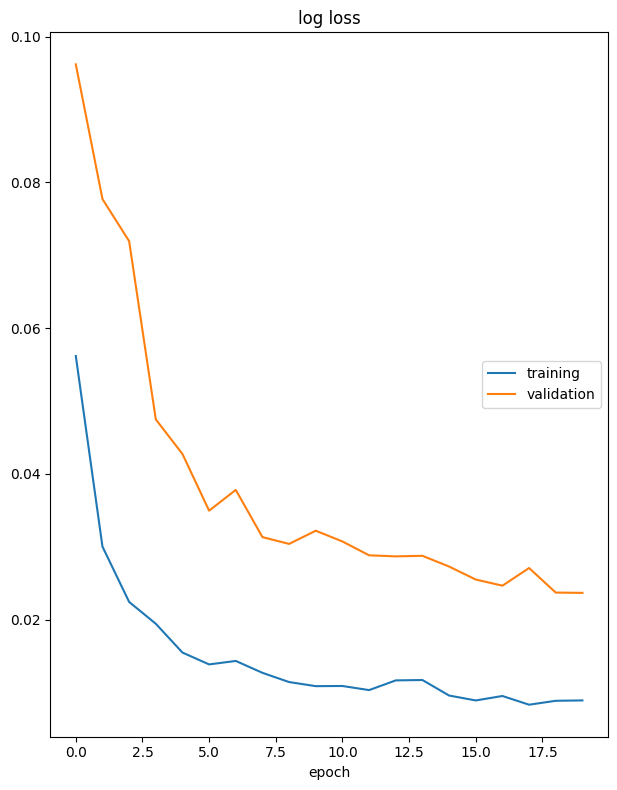

log loss
	training         	 (min:    0.008, max:    0.056, cur:    0.009)
	validation       	 (min:    0.024, max:    0.096, cur:    0.024)


In [13]:
def train(model, train_loader, val_loader, epochs=10):
    # Initializing the optimizer for the model parameters
    optim = torch.optim.Adam(model.parameters())
    liveloss = PlotLosses()  # Object to track validation and training losses across epochs
    # alpha = 0.5  # parameter to weigh the L1 and dice losses
    l1_loss = torch.nn.L1Loss()
    for epoch in range(epochs):
        logs = {}
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        for batch_input, batch_target in tqdm(train_loader):
            batch_input = batch_input.to(device)
            batch_target = batch_target.to(device)
            optim.zero_grad()  # resetting gradients
            batch_output = model(batch_input)  # generating images
            # loss = alpha * dice_loss(batch_output, batch_target) + (1 - alpha) * RE_loss(batch_output, batch_target)
            loss = l1_loss(batch_output, batch_target)
            loss.backward()  # backprop
            optim.step()
            train_loss += loss.item()

        # Validation loop
        with torch.no_grad():
            for batch_input, batch_target in tqdm(train_loader):
                batch_input = batch_input.to(device)
                batch_target = batch_target.to(device)
                batch_output = model(batch_input)
                # loss = alpha * dice_loss(batch_output, batch_target) + (1 - alpha) * RE_loss(batch_output, batch_target)
                loss = l1_loss(batch_output, batch_target)
                val_loss += loss.item()

        # Calculate average losses (to make it independent of batch size)
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Log the losses for plotting
        logs['log loss'] = avg_train_loss
        logs['val_log loss'] = avg_val_loss

        liveloss.update(logs)
        liveloss.send()
    return model

trained_model = train(model, train_loader, val_loader, epochs=20)
torch.save(trained_model, 'drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/models/unet-v1.pth')

In [13]:
trained_model = torch.load('drive/MyDrive/Colab Notebooks/prototwin/deep-learning-dose-activity-dictionary/models/unet-v1.pth', map_location=torch.device(device))

# Detach if running out of memory
# output.detach()
# torch.cuda.empty_cache()

# Loading a few examples
input, target = next(iter(train_loader))
trained_model_eval = trained_model.eval()  # Putting the model in training mode
output = trained_model_eval(input.to(device))

8


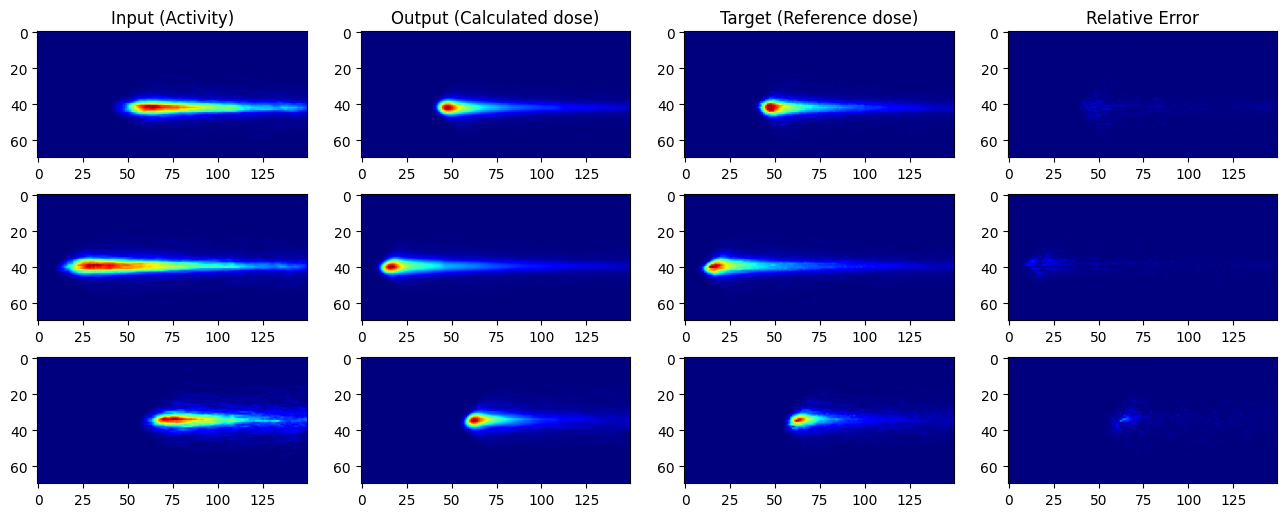

In [17]:

n_plots = 3
fig, axs = plt.subplots(n_plots, 4, figsize=[16, 6])
print(input.shape[0])

# Add titles to the columns
column_titles = ['Input (Activity)', 'Output (Calculated dose)', 'Target (Reference dose)', 'Relative Error']
for ax, col in zip(axs[0], column_titles):
    ax.set_title(col)

for idx in range(3):
    y_slice = 30
    input_img = input[idx].cpu().detach().squeeze(0)[:,y_slice,:]
    out_img = output[idx].cpu().detach().squeeze(0)[:,y_slice,:]
    target_img = target[idx].cpu().detach().squeeze(0)[:,y_slice,:]
    diff_img = abs(target_img - out_img)
    axs[idx, 0].imshow(input_img.T, cmap='jet')
    axs[idx, 1].imshow(out_img.T, cmap='jet')
    axs[idx, 2].imshow(target_img.T, cmap='jet')
    axs[idx, 3].imshow(diff_img.T, cmap='jet', vmax=torch.max(target_img))

In [36]:
# Relative error to see how well are model does

def RE_loss(output, target):  # Relative error loss
    output = mean_output + output * std_output  # undoing normalization
    target = mean_output + target * std_output
    abs_diff = output - target
    max_intensity= torch.amax(target, dim=[1,2,3])
    loss = abs_diff / max_intensity.view(-1, 1, 1, 1) * 100
    mean_RE = torch.mean(loss, dim=[1, 2, 3])
    std_RE = torch.std(loss, dim=[1, 2, 3])
    return mean_RE, std_RE

print(RE_loss(output, target))

(tensor([ 0.0011, -0.0111,  0.0006, -0.0030, -0.0127,  0.0032, -0.0003, -0.0008],
       grad_fn=<MeanBackward1>), tensor([0.1728, 0.2056, 0.2367, 0.2251, 0.2109, 0.2147, 0.1146, 0.1083],
       grad_fn=<StdBackward0>))


In [25]:
# Test loop (after the training is complete)
test_loss = 0.0
with torch.no_grad():
    for batch_input, batch_target in test_loader:
        batch_input = batch_input.to(device)
        batch_output = model(batch_input)
        # loss = alpha * dice_loss(batch_output, batch_target) + (1 - alpha) * l1_loss(batch_output, batch_target)
        loss = RE_loss(batch_output, batch_target)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)
print(f"Average Test Loss: {avg_test_loss}")

OutOfMemoryError: ignored